## Goal
To implement machine learning models in predicting the behavior of different cryptocurrencies by analyzing their features and their behavior in the market over time.

## Dataset
For this project, we will use the dataset provided by **G-Research** from *Kaggle*. This dataset contains more than 24 million rows and 10 columns in the training set.
Since we are to predict the future values of cryptocurrencies, this is a **Regression Problem**.

## Features
We can see the different features included in the dataset. Specifically, the features included per asset are the following:

* **timestamp**
All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
* **Asset_ID**
The asset ID corresponding to one of the cryptocurrencies (e.g. `Asset_ID` = 1 for Bitcoin). The mapping from `Asset_ID` to crypto asset is contained in `asset_details.csv`.
* **Count**
Total number of trades in the time interval (last minute).
* **Open**
Opening price of the time interval (in USD).
* **High**
Highest price reached during time interval (in USD).
* **Low**
Lowest price reached during time interval (in USD).
* **Close**
Closing price of the time interval (in USD).
* **Volume**
Quantity of asset bought or sold, displayed in base currency USD.
* **VWAP**
The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
* **Target**
Residual log-returns for the asset over a 15 minute horizon.

The first two columns define the time and asset indexes for this data row. The 6 middle columns are feature columns with the trading data for this asset and minute in time.
The last column is the prediction target, which we will get to later in more detail.

We also view the asset information, including the list of all assets, the `Asset_ID` to asset mapping, and the weight of each asset used to weigh their relative importance in the evaluation metric.

## Evaluation
Since this is a regression problem, we will evaluate our machine learning models using **Mean Absolute Error (MAE)**

## Workflow
We are going to follow these steps for this project:
1. Import necessary libraries and data
2. Explore the data
3. Visualize the data
4. Deal with missing values
5. Show correlation between assets
6. Feature design
7. Preprocess the data
8. Split the data for training
9. Train machine learning models
10. Evaluate scores

### Dependencies Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import plotly
import time

In [4]:
print("Pandas version", pd.__version__)
print("NumPy version", np.__version__)
print("Matplotlib version", matplotlib.__version__)
print("Seaborn version", sns.__version__)
print("Plotly version", plotly.__version__)
print("Scikit-Learn version", sklearn.__version__)

Pandas version 1.5.3
NumPy version 1.22.4
Matplotlib version 3.7.1
Seaborn version 0.12.2
Plotly version 5.13.1
Scikit-Learn version 1.2.2


In [5]:
from plotly import graph_objects
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

### Data Import

In [6]:
dframe = pd.read_csv("train.csv")
details = pd.read_csv("asset_details.csv")

FileNotFoundError: ignored

In [ ]:
details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [ ]:
details.sort_values(by="Asset_ID", inplace=True)
details

,Asset_ID,Weight,Asset_Name
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
0,2,2.397895,Bitcoin Cash
10,3,4.406719,Cardano
13,4,3.555348,Dogecoin
3,5,1.386294,EOS.IO
5,6,5.894403,Ethereum
4,7,2.079442,Ethereum Classic
11,8,1.098612,IOTA
6,9,2.397895,Litecoin


### Data Exploration

In [ ]:
dframe.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


In [ ]:
print("Number of Rows:", dframe.shape[0])
print("Number of Columns:", dframe.shape[1])

Number of Rows: 24236806
Number of Columns: 10


In [ ]:
dframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [ ]:
dframe.isna().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [ ]:
dframe.columns

Index(['timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close',
       'Volume', 'VWAP', 'Target'],
      dtype='object')

### Dealing with missing data

In [ ]:
# Let's see what we have for Bitcoin

btc = dframe[dframe["Asset_ID"] == 1].set_index("timestamp")
btc.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956282 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Asset_ID  1956282 non-null  int64  
 1   Count     1956282 non-null  float64
 2   Open      1956282 non-null  float64
 3   High      1956282 non-null  float64
 4   Low       1956282 non-null  float64
 5   Close     1956282 non-null  float64
 6   Volume    1956282 non-null  float64
 7   VWAP      1956282 non-null  float64
 8   Target    1955978 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 149.3 MB


We can see that there are some missing values for `Target` column

In [ ]:
btc.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64

For a given moment, missing value of an asset isn't represented by NaN, rather those entire rows remain absent. We can check `timestamp` difference between rows to check if there's any missing data.

In [ ]:
# Check the `timestamp` difference between consecutive rows to see missing data

(btc.index[1:] - btc.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

In [ ]:
btc = btc.reindex(range(btc.index[0], btc.index[-1] + 60, 60), method='pad')

In [ ]:
(btc.index[1:] - btc.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

### Data Visualization

In [ ]:
# Function that plots about assets & fills missing values

def plot_assets(asset1_id, asset2_id=None, subplot=True):
    fig = plt.figure(figsize=(15, 4))
    asset1 = dframe[dframe["Asset_ID"] == asset1_id].set_index("timestamp")
    asset1 = asset1.reindex(range(asset1.index[0], asset1.index[-1] + 60, 60), method='pad')

    if subplot:
        asset2 = dframe[dframe["Asset_ID"] == asset2_id].set_index("timestamp")
        asset2 = asset2.reindex(range(asset2.index[0], asset2.index[-1] + 60, 60), method='pad')

        ax1 = fig.add_subplot(121)
        lb = details["Asset_Name"].values[asset1_id]
        plt.plot(asset1["Close"], label=lb, color="red")
        plt.legend()
        plt.xlabel("Time")
        plt.ylabel(lb)

        ax2 = fig.add_subplot(122)
        lb = details["Asset_Name"].values[asset2_id]
        plt.plot(asset2["Close"], label=lb)
        plt.legend()
        plt.xlabel("Time")
        plt.ylabel(lb)

    else:
        lb = details["Asset_Name"].values[asset1_id]
        plt.plot(asset1["Close"], label=lb)
        plt.legend()
        plt.xlabel("Time")
        plt.ylabel(lb)

    plt.tight_layout()
    plt.show()

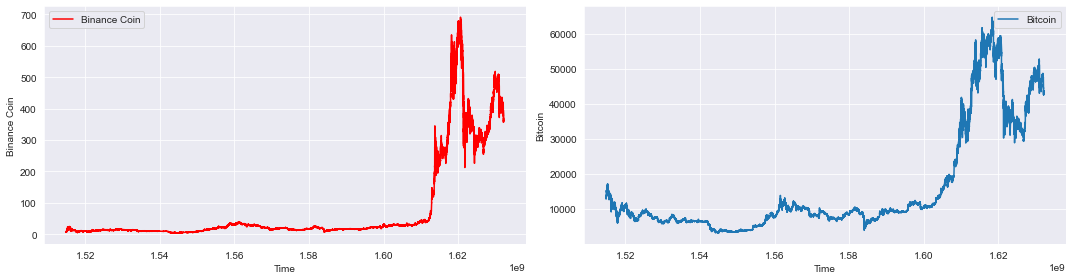

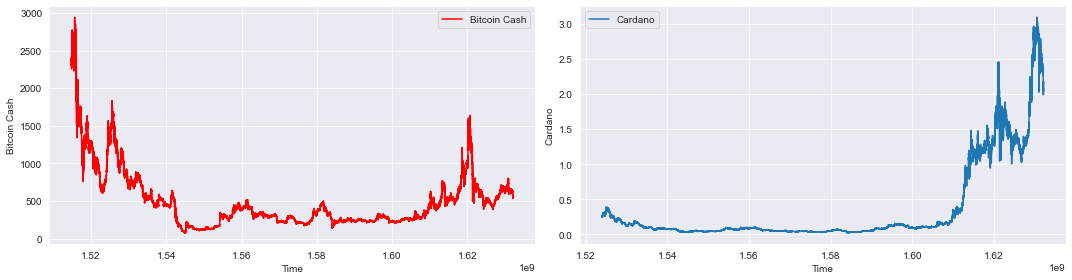

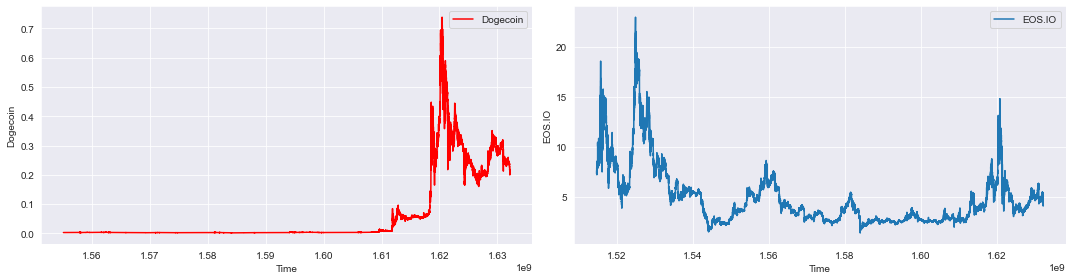

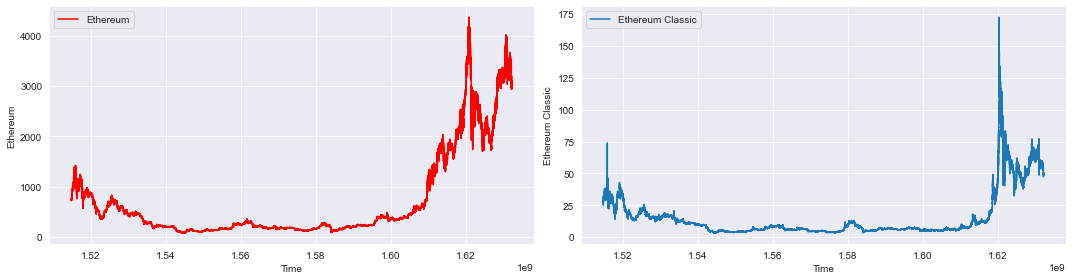

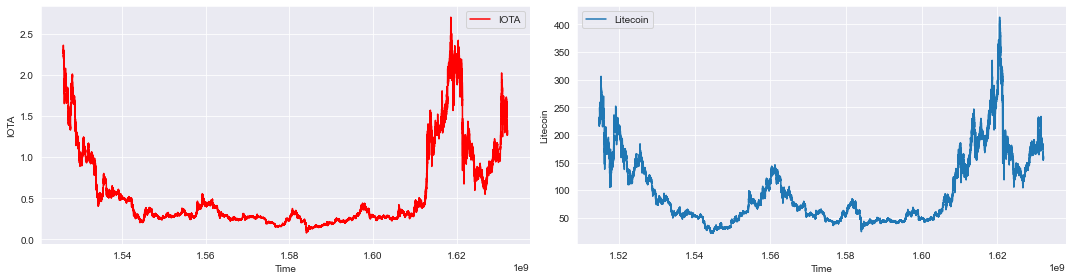

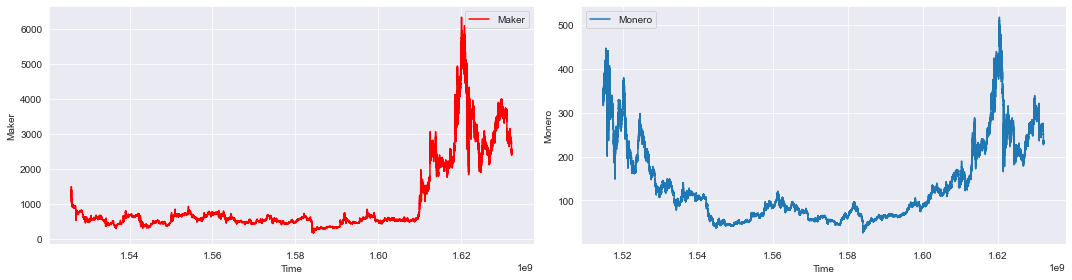

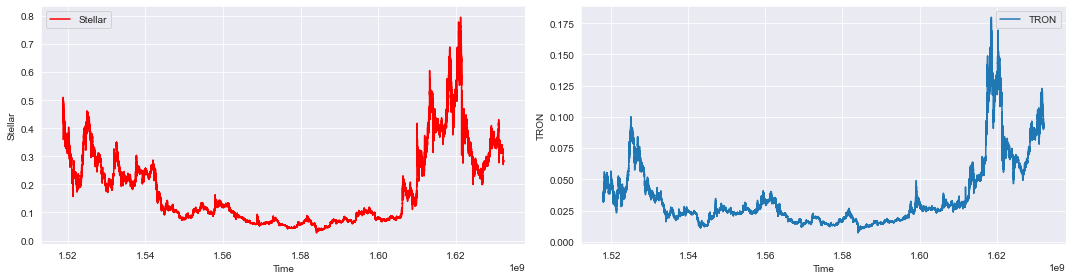

In [ ]:
for a in range(0, 14, 2):
    plot_assets(a, a+1)

In [ ]:
# Function that changes datetime

def show_datetime(asset_id):
    asset = dframe[dframe["Asset_ID"] == asset_id].set_index("timestamp")
    beg_asset = asset.index[0].astype('datetime64[s]')
    end_asset = asset.index[-1].astype('datetime64[s]')

    return beg_asset, end_asset

In [ ]:
# Example: Show datetime for Ethereum (Asset ID = 6)

a, b = show_datetime(1)
print(f"Bitcoin data goes from {a} to {b}")

a, b = show_datetime(6)
print(f"Ethereum data goes from {a} to {b}")

Bitcoin data goes from 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Ethereum data goes from 2018-01-01T00:01:00 to 2021-09-21T00:00:00


In [ ]:
to_timestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

In [ ]:
btc = dframe[dframe["Asset_ID"] == 1].set_index("timestamp")
eth = dframe[dframe["Asset_ID"] == 6].set_index("timestamp")
ada = dframe[dframe["Asset_ID"] == 3].set_index("timestamp")

btc_2021 = btc.loc[to_timestamp('01/06/2021'):to_timestamp('01/07/2021')]
eth_2021 = eth.loc[to_timestamp('01/06/2021'):to_timestamp('01/07/2021')]
ada_2021 = ada.loc[to_timestamp('01/06/2021'):to_timestamp('01/07/2021')]

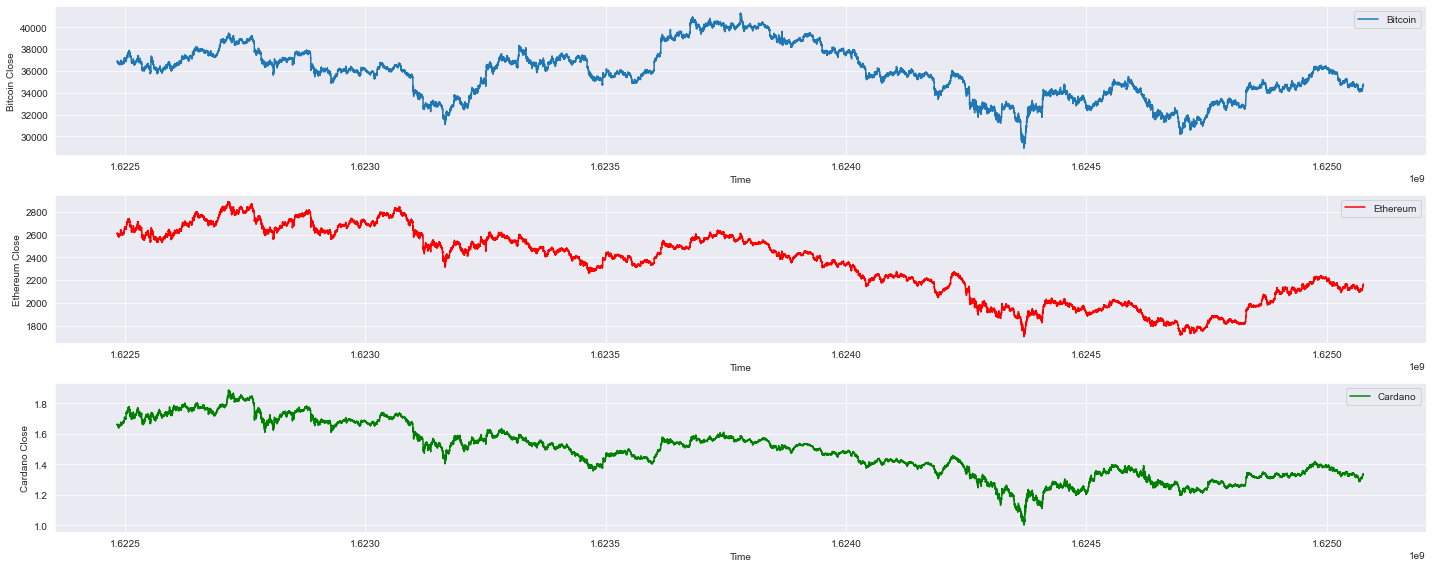

In [ ]:
f = plt.figure(figsize=(20,8))

ax = f.add_subplot(311)
plt.plot(btc_2021['Close'], label='Bitcoin')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Close')

ax2 = f.add_subplot(312)
ax2.plot(eth_2021['Close'], color='red', label='Ethereum')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum Close')

ax3 = f.add_subplot(313)
ax3.plot(ada_2021['Close'], color='green', label='Cardano')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cardano Close')

plt.tight_layout()
plt.show()

### Analyze Price Change
Since different assets exhibit different price scale, we cannot simply deal with the price difference in order to analyze price change as they are not comparable. But we can solve this problem by computing the percentage change in price which is commonly known as Return widely used in Finance.
We shall prefer "log return" for mathematical modelling since we are also dealing with time series. Also, log returns can go below 100% that makes them unbounded. To compute the log return, we can simply take the logarithm of the ratio between two consecutive prices. The first row will have an empty return as the previous value is unknown, therefore the empty return data point will be dropped.

In [ ]:
# Function that computes log returns

def log_returns(series, periods=1):
    return np.log(series).diff(periods=periods)

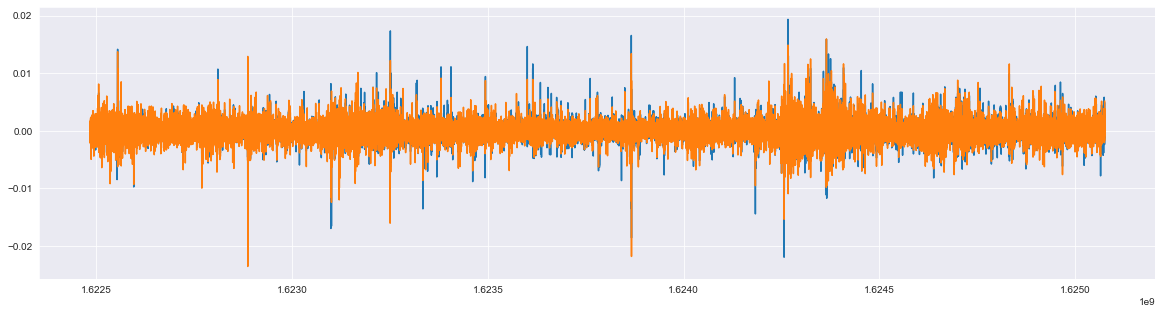

In [ ]:
# Visualize the log return for Bitcoin & Ethereum

log_ret_btc_mini = log_returns(btc_2021.Close)[1:]
log_ret_eth_mini = log_returns(eth_2021.Close)[1:]

log_ret_btc_mini.rename('log_ret_btc', inplace=True)
log_ret_eth_mini.rename('log_ret_eth', inplace=True)

plt.figure(figsize=(20,5))
plt.plot(log_ret_btc_mini)
plt.plot(log_ret_eth_mini)
plt.show()

### Correlation between assets
We check the correlation between Bitcoin and Ethereum over time for the year 2021

In [ ]:
log_ret_btc_long = log_returns(btc["Close"])[1:]
log_ret_eth_long = log_returns(eth["Close"])[1:]

log_ret_btc_long.rename('log_ret_btc', inplace=True)
log_ret_eth_long.rename('log_ret_eth', inplace=True)

two_assets = pd.concat([log_ret_btc_long, log_ret_eth_long],
                       axis=1)

In [ ]:
corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:, "log_ret_btc"].loc[:, "log_ret_eth"]

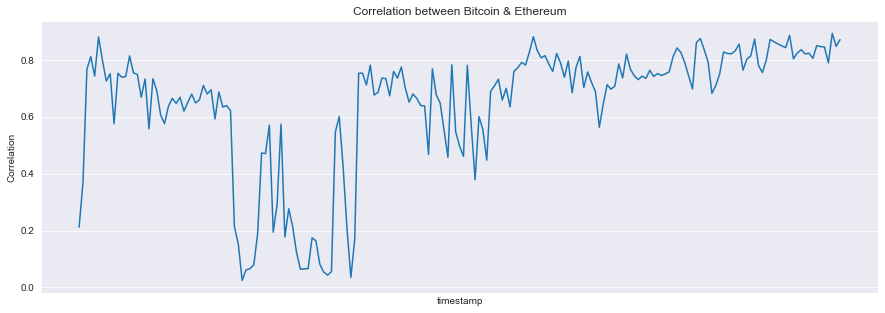

In [ ]:
corr_time.plot(figsize=(15, 5))
plt.xticks([])
plt.ylabel("Correlation")
plt.title("Correlation between Bitcoin & Ethereum");

### Dataframe with Returns of all assets

In [ ]:
all_assets_2021 = pd.DataFrame([])

for asset_id, asset_name in zip(details["Asset_ID"], details["Asset_Name"]):
  asset = dframe[dframe["Asset_ID"] == asset_id].set_index("timestamp")
  asset = asset.loc[to_timestamp('01/01/2021'): to_timestamp('01/05/2021')]
  asset = asset.reindex(range(asset.index[0], asset.index[-1]+60, 60), method='pad')

  log_ret = log_returns(asset["Close"].fillna(0))[1:]
  all_assets_2021 = all_assets_2021.join(log_ret, rsuffix=asset_name, how="outer")

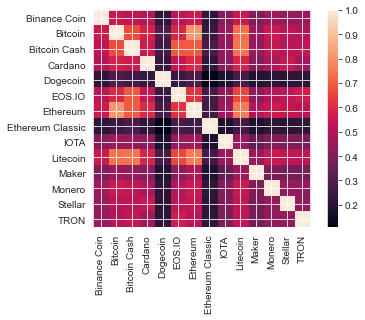

In [ ]:
plt.imshow(all_assets_2021.corr())
plt.yticks(range(14), details["Asset_Name"].values)
plt.xticks(range(14), details["Asset_Name"].values, rotation='vertical')
plt.colorbar();

### Feature Design

In [ ]:
upper_shadow = lambda asset: asset["High"] - np.maximum(asset["Close"], asset["Open"])
lower_shadow = lambda asset: np.minimum(asset["Close"], asset["Open"] - asset["Low"])

In [ ]:
X_btc = pd.concat([log_returns(btc["VWAP"], periods=5),
                  log_returns(btc["VWAP"], periods=1).abs(),
                  upper_shadow(btc),
                  lower_shadow(btc)],
                  axis=1)
y_btc = btc["Target"]

X_eth = pd.concat([log_returns(eth["VWAP"], periods=5),
                  log_returns(eth["VWAP"], periods=1).abs(),
                  upper_shadow(eth),
                  lower_shadow(eth)],
                  axis=1)
y_eth = eth["Target"]

### X and y Split

In [ ]:
train_window = [to_timestamp("01/05/2021"), to_timestamp("30/05/2021")] # May 2021
test_window = [to_timestamp("01/06/2021"), to_timestamp("01/06/2021")] # June 2021

In [ ]:
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

### Scale the data

In [ ]:
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

## Machine Learning Models
The machine learning models that we are going to use for this project are imported from Scikit-Learn. These are as follows:
1. Linear Regressor
2. K-Neighbor Regressor
3. Random Forest Regressor
4. ElasticNet Regressor
5. Ridge Regressor

### Linear Regression

In [ ]:
lr = LinearRegression()

lr.fit(X_btc_train_scaled, y_btc_train)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

lr.fit(X_eth_train_scaled, y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled)

### K-Neighbors Regressor

In [ ]:
kn = KNeighborsRegressor()

kn.fit(X_btc_train_scaled, y_btc_train)
y_pred_kn_btc = kn.predict(X_btc_test_scaled)

kn.fit(X_eth_train_scaled, y_eth_train)
y_pred_kn_eth = kn.predict(X_eth_test_scaled)

### Random Forest Regressor

In [ ]:
rf = RandomForestRegressor()

rf.fit(X_btc_train_scaled, y_btc_train)
y_pred_rf_btc = rf.predict(X_btc_test_scaled)

rf.fit(X_eth_train_scaled, y_eth_train)
y_pred_rf_eth = rf.predict(X_eth_test_scaled)

### ElasticNet

In [ ]:
en = ElasticNet()

en.fit(X_btc_train_scaled, y_btc_train)
y_pred_en_btc = en.predict(X_btc_test_scaled)

en.fit(X_eth_train_scaled, y_eth_train)
y_pred_en_eth = en.predict(X_eth_test_scaled)

### Ridge Regression

In [ ]:
rg = Ridge()

rg.fit(X_btc_train_scaled, y_btc_train)
y_pred_rg_btc = rg.predict(X_btc_test_scaled)

rg.fit(X_eth_train_scaled, y_eth_train)
y_pred_rg_eth = rg.predict(X_eth_test_scaled)

## Model Evaluation

In [ ]:
# Mean Absolute Error
error_btc = {
    "Random Forest": round(mean_absolute_error(y_btc_test, y_pred_rf_btc), 6),
    "Ridge": round(mean_absolute_error(y_btc_test, y_pred_rg_btc), 6),
    "ElasticNet": round(mean_absolute_error(y_btc_test, y_pred_en_btc), 6),
    "K-Neighbor": round(mean_absolute_error(y_btc_test, y_pred_kn_btc), 6),
    "Linear": round(mean_absolute_error(y_btc_test, y_pred_lr_btc), 6)
}
error_eth = {
    "Random Forest": round(mean_absolute_error(y_eth_test, y_pred_rf_eth), 6),
    "Ridge": round(mean_absolute_error(y_eth_test, y_pred_rg_eth), 6),
    "ElasticNet": round(mean_absolute_error(y_eth_test, y_pred_en_eth), 6),
    "K-Neighbor": round(mean_absolute_error(y_eth_test, y_pred_kn_eth), 6),
    "Linear": round(mean_absolute_error(y_eth_test, y_pred_lr_eth), 6)
}

print(error_btc)
print(error_eth)

{'Random Forest': 0.001441, 'Ridge': 0.001054, 'ElasticNet': 0.000905, 'K-Neighbor': 0.001698, 'Linear': 0.001054}
{'Random Forest': 0.000355, 'Ridge': 0.000307, 'ElasticNet': 0.00032, 'K-Neighbor': 0.001551, 'Linear': 0.000307}


In [ ]:
def plot_errors(asset_errors, name):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(asset_errors.keys(), asset_errors.values())
    ax.set_title(f"Error of different models for {name} data")
    ax.set_xlabel("The lesser the better");

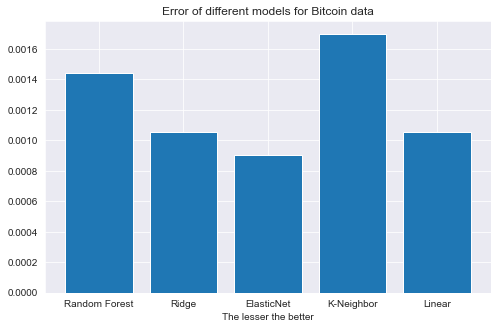

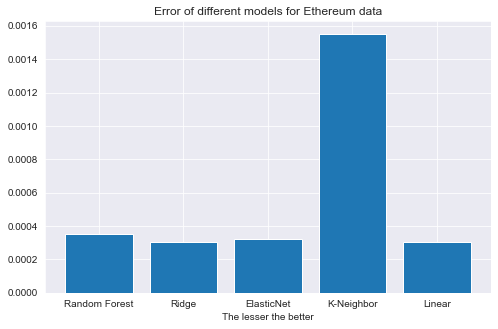

In [ ]:
plot_errors(error_btc, "Bitcoin")
plot_errors(error_eth, "Ethereum")